# Preprocessing and Feature Extraction

[Reading the dataset folders](#Reading-the-dataset-folders):
- KAP, the dataset that contains events from 3 kinetic-augmented bases "NA", "R1", "M1"
- NO_KAA, the dataset that contains events from 3 different pill bottles without augmentation "B1", "B2", "B3"

[Preprocessing each event](#Preprocessing-each-event):
- We normalize based on the greatest peak of each event detected
- We isolate a frequency band between 500 Hz - 600 Hz

[Feature Extraction](#Feature-Extraction):
- energy decay, in the form of clamped peak count at different amplitude levels
- peak interval comparing the first 3 peaks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from pathlib import Path

# map for folder and file locations
input_files = {"KAA/events": ((("KAA","npy"),),("NA", "R1", "M1"),("middle", "topright", "bottomright", "bottomleft", "topleft")),
              "NO_KAA/events": ((("no_KAA","mat"),),("B1", "B2", "B3"),("middle", "topright", "bottomright", "bottomleft", "topleft")),
              }

## Reading the dataset folders

In [2]:
# read all data
data = dict()
for folder,info in input_files.items():
    ppl, augs, locs = info
    # print(ppl)
    for pers in ppl:
        pers_name, filetype = pers
        data[pers_name] = dict()
        for loc in locs:
            data[pers_name][loc] = dict()
            for aug in augs:
                if filetype == "npy":
                    data[pers_name][loc][aug] = np.load(f"./{folder}/{pers_name}_{aug}_{loc}.npy")
                elif filetype == "mat":
                    _arr = loadmat(f"./{folder}/{pers_name}_{aug}_{loc}.mat")
                    data[pers_name][loc][aug] = np.array([x[0] for x in _arr["filteredEvents"].flatten()])
                elif filetype == "csv":
                    data[pers_name][loc][aug] = np.loadtxt(f"./{folder}/{pers_name}_{aug}_{loc}.csv", delimiter=',')
                # print(data[pers_name][loc][aug])

/tmp/ipykernel_13227/399772107.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data[pers_name][loc][aug] = np.array([x[0] for x in _arr["filteredEvents"].flatten()])


## Preprocessing each event

In [3]:
from scipy import signal, stats, optimize
from pathlib import Path
preprocessed_data = dict()
for folder,info in input_files.items():
    ppl, augs, locs = info
    for pers in ppl:
        pers_name, filetype = pers
        preprocessed_data[pers_name] = dict()
        for loc in locs:
            preprocessed_data[pers_name][loc] = dict()
            for aug in augs:
                _output = list()
                _ffts = list()
                for i in range(len(data[pers_name][loc][aug])):
                    
                    # stft
                    ex = data[pers_name][loc][aug][i]
                    ex = ex - ex.mean()
                    
                    # normalize raw signal
                    eng = np.sqrt(np.sum(ex**2))
                    ex = ex / eng
                    tmp_fft = np.fft.fft(ex, n = 2350)
                    abs_fft = np.abs(tmp_fft)
                    _ffts.append(abs_fft[:1174])
                    
                    # stft
                    f, t, Zxx = signal.stft(ex,2400, nperseg=25)
                    Zxx = np.abs(Zxx)
                    
                    # band pass 500 Hz - 600 Hz
                    band = np.where(np.logical_and(f > 700, f < 800))
                    f_band_pass = f[band]
                    Zxx_band_pass = Zxx[band]
                    
                    # moving average for filtering
                    def moving_average(a, n=3):
                        ret = np.cumsum(a, dtype=float)
                        ret[n:] = ret[n:] - ret[:-n]
                        return ret[n - 1:] / n
                    Zxx_band_pass = moving_average(Zxx_band_pass[0], n=3)
        
                    # get abs
                    Zxx_band_pass = np.abs(Zxx_band_pass)
            
                    # set to normalized scale
                    exp = np.max(Zxx_band_pass)
                    Zxx_band_pass = Zxx_band_pass / exp

                    # saved to preprocessed_data
                    _output.append(Zxx_band_pass)
                preprocessed_data[pers_name][loc][aug] = _output
                # save to file
                np.save(f"{folder}/{pers_name}_{aug}_{loc}_fft.npy", _ffts)

## Feature Extraction

In [4]:
# helper functions
from scipy import signal, stats

def get_clamped_peak_counts(event, clamp_value=2, debug=None):
    ''' get clamped peak count features, never going over the clamp_value

        return iterator(int)
    '''

    # # store a list of clampled values greater than 1
    cl_values = list()
    
    # select different peak threshholds
    clamped_values = list()
    for i in np.arange(0.2,1,0.2):
        peaks_y = list(signal.find_peaks(event, height=i, distance=5)[1]["peak_heights"])
        
        # processing starting of the signal
        if event[0] > 0.1:
            peaks_y.append(0)
            peaks_y.append(event[0])
        
        # clamp value
        clamped_value = min(clamp_value, len(peaks_y))
        if (debug is not None) and clamped_value > 1:
            cl_values.append(i)
            debug[loc][aug].append(i)

        clamped_values.append(clamped_value)
        
    # also return median value
    clamped_values.append(0 if len(cl_values) == 0 else sorted(cl_values)[len(cl_values) // 2])
    return clamped_values


def get_peaks(event):
    '''get indices and amplitude of peaks from event

        return peaksx(list(int)), peaksy(list(int))
    '''
    
    # get peaks
    all_x_peaks = list(signal.find_peaks(event, height=0.1, distance=10)[0])
    all_y_peaks = list(event[all_x_peaks])
    if event[0] > 0.1:
        all_x_peaks.append(0)
        all_y_peaks.append(event[0])

    # signal end threshhold
    all_x_peaks.append(len(event))
    all_y_peaks.append(0.1)
    return all_x_peaks, all_y_peaks

        
def get_median_peak_interval_ratio(event, debug=None):
    ''' get median eak interval ratio, the first peak divided by the second peak, to estimate energy decay

        return int
    '''
    # get peaks
    all_x_peaks, _ = get_peaks(event)
    

    # get first peak intervals
    peak_intervals = list()
    for i in range(len(all_x_peaks) - 1):
        peak_intervals.append(all_x_peaks[i + 1] - all_x_peaks[i]) 

    if len(peak_intervals) == 0:
        peak_interval = 200
    else:
        peak_interval = sorted(peak_intervals)[len(peak_intervals) // 2]
    debug[loc][aug].append(peak_interval)
    return peak_interval



In [5]:
_peaks = dict()
_ratios = dict()
_intervals = dict()
all_debug_features = (_peaks, _ratios, _intervals)
all_debug_features_names = ("_peaks", "_ratios", "_intervals")

from scipy import signal, stats, optimize
for folder,info in input_files.items():
    ppl, augs, locs = info
    for pers in ppl:
        pers_name, filetype = pers
        for debug_features in all_debug_features:
            debug_features[pers_name] = {loc: {aug: list() for aug in augs} for loc in locs}
        for loc in locs:
            for aug in augs:
                n_features = list()
                for i in range(len(data[pers_name][loc][aug])):
                    # get preprocessed event
                    event = preprocessed_data[pers_name][loc][aug][i]
                    
                    # list of features
                    features = list()

                    
                    # get list of clamped peak counts
                    for _clamped_peak_counts in get_clamped_peak_counts(event, debug=_peaks[pers_name]):
                        features.append(_clamped_peak_counts)
                    
                    # get median peak interval ratio
                    features.append(get_median_peak_interval_ratio(event, debug=_intervals[pers_name]))
                    
                    # add features to event list
                    n_features.append(features)
                    
                n_features = np.array(n_features)
                # print(f"{pers}_{aug}_{loc}_features.npy")
                np.save(f"./{folder}/{pers_name}_{aug}_{loc}_features.npy",n_features)

### Visualize Features

In [6]:
def visualize_features():
    for loc,_d in _intervals.items():
        for k,v in _d.items():
            plt.hist(v, label=k)
        plt.legend()
        plt.title(loc)
        plt.show()
    for folder,info in input_files.items():
        ppl, augs, locs = info
        for pers in ppl:
            pers_name, filetype = pers
            for feature_name, debug_features in zip(all_debug_features_names, all_debug_features):
                print(feature_name)
                fig, axs = plt.subplots(2)
                for i, loc in enumerate(["bottomleft", "topleft"]):
                    for aug in debug_features[pers_name][loc].keys():
                        features = debug_features[pers_name][loc][aug]
                        axs[i].hist(features, label=aug)
                    axs[i].legend()
                    axs[i].set_title(f'{folder}: {loc}')
                fig.set_dpi(100)
                plt.show()

# visualize_features()

# Training and Evaluation

Using the KAP dataset:
- [find accuracy with no LOO (90% dataset for training)](KAP-NO-LOO)
- [find accuracy with LOO](KAP-LOO)
- [find accuracy with just FFT (no KAFE) with LOO](KAP-FFT)

Using the NO_KAA dataset:
- [find accuracy with just FFT (no KAFE) with LOO](NO-KAA-FFT)

## Preamble

In [7]:
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tuning import svmTuning
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

all_ffts = dict()
all_features = dict()
for folder,info in input_files.items():
    ppl, augs, locs = info
    augment_keys = {k:n for n,k in enumerate(augs)}
    for pers in ppl:
        pers_name, filetype = pers
        all_features[pers_name] = dict()
        all_ffts[pers_name] = dict()
        d = all_features[pers_name]
        d2 = all_ffts[pers_name]
        for loc in locs:
            all_features[pers_name][loc] = dict()
            all_ffts[pers_name][loc] = dict()
            for aug in augs:
                _arr = np.load(f"{folder}/{pers_name}_{aug}_{loc}_features.npy")
                _fft = np.load(f"{folder}/{pers_name}_{aug}_{loc}_fft.npy")
                

                if _arr.shape[0] == 0:
                    print(f"{folder}/{pers_name}_{aug}_{loc}_features.npy")
                scaler = StandardScaler().set_output(transform="pandas")
                # scale data
                _arr = scaler.fit_transform(_arr)
                # add labels
                _arr = np.c_[_arr, np.ones(_arr.shape[0])*augment_keys[aug]]
                _fft = np.c_[_fft, np.ones(_fft.shape[0])*augment_keys[aug]]
                # assert that there are no missing features
                assert not np.isnan(_arr[:,7:]).any(), f"contains nan in {folder}/{pers_name}_{aug}_{loc}"
                # save to all_features
                d[loc][aug] = _arr
                d2[loc][aug] = _fft
            

# EXAMPLE: M1_ALL_AUGMENTS_ALL_LOCATIONS
def tune(X_train, y_train, X_test, y_test):
    '''tunes both with linear and rbf. For our purposese, only show rsvm_acc'''
    # define classifers
    clf_lsvm = SVC(kernel = 'linear')
    clf_rsvm = SVC(kernel = 'rbf')
    
    # tune and print result (tuned_lsvm, tuned_rsvm, lsvm_acc, rsvm_acc)
    results = svmTuning(X_train, y_train, X_test, y_test, clf_lsvm, clf_rsvm, 3)
    # print(results[2:])
    return results

def get_dataset(d):
    '''return copy of the dataset'''
    dataset = []
    for loc in d.keys():
        for aug in d[loc].keys():
            dataset.extend(d[loc][aug])
    return np.array(dataset)

def get_dataset_location_picky(d, l):
    '''returns leave one out based on location of the dataset'''
    train = []
    test = []
    for loc in d.keys():
        if l == loc:
            # print("=")
            for aug in d[loc].keys():
                test.extend(d[loc][aug])
        else:
            for aug in d[loc].keys():
                train.extend(d[loc][aug])
    return np.array(train), np.array(test)


## KAP NO LOO

In [8]:
# KAP no LOO (90% training)
kap_no_loo = list()
for pers_name in ["KAA"]:

    for loc in all_features[pers_name]:
        _r = list()
        for _i in range(20):
            rest_dataset, loc_dataset = get_dataset_location_picky(all_features[pers_name], loc)
            locX_train, locX_test, locy_train, locy_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
                                                      train_size=0.9, random_state=_i, stratify=loc_dataset[:, -1])
            restX_train, restX_test, resty_train, resty_test = train_test_split(rest_dataset[:, :-1], rest_dataset[:, -1],
                                                      train_size=0.9, random_state=_i, stratify=rest_dataset[:, -1])

            _, clf, _, acc = tune(np.concatenate((restX_train,locX_train)), np.concatenate((resty_train,locy_train)), locX_test, locy_test)
            _r.append(acc)
        accuracy_results_percentage = [loc, np.average(_r), np.std(_r)]
        print(accuracy_results_percentage)
        kap_no_loo.append(accuracy_results_percentage)

['middle', 0.99, 0.02380476142847616]
['topright', 0.9666666666666668, 0.039440531887330765]
['bottomright', 0.9833333333333334, 0.02886751345948128]
['bottomleft', 1.0, 0.0]
['topleft', 0.9933333333333334, 0.02]


## KAP LOO

In [9]:
# KAP_LOO
kap_loo = list()
for pers_name in ["KAA"]:
    for loc in all_features[pers_name]:
        _r = list()
        for _i in range(20):
            rest_dataset, loc_dataset = get_dataset_location_picky(all_features[pers_name], loc)
            locX_train, locX_test, locy_train, locy_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
                                                      train_size=0.9, random_state=_i, stratify=loc_dataset[:, -1])
            _, clf, _, acc = tune(rest_dataset[:, :-1], rest_dataset[:, -1], locX_test, locy_test)
            _r.append(acc)
        accuracy_results_percentage = [loc, np.average(_r), np.std(_r)]
        print(accuracy_results_percentage)
        kap_loo.append(accuracy_results_percentage)

['middle', 0.8700000000000001, 0.09303523824635243]
['topright', 0.9166666666666667, 0.06280481227138925]
['bottomright', 0.8700000000000001, 0.061373175465073225]
['bottomleft', 0.4333333333333334, 0.0649786289653931]
['topleft', 1.0, 0.0]


## KAP FFT

In [10]:
# KAP_FFT (no KAFE)
kap_fft = list()
for pers_name in ["KAA"]:
    for loc in all_ffts[pers_name]:
        _r = list()
        for _i in range(20):
            rest_dataset, loc_dataset = get_dataset_location_picky(all_ffts[pers_name], loc)
            rest_dataset = np.c_[np.abs(rest_dataset[:,:-1]),rest_dataset[:,-1:]]
            loc_dataset = np.c_[np.abs(loc_dataset[:,:-1]),loc_dataset[:,-1:]]
            _, locX_test, _, locy_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
                                                      train_size=0.9, random_state=_i, stratify=loc_dataset[:, -1])
            _, clf, _, acc = tune(rest_dataset[:, :-1], rest_dataset[:, -1], locX_test, locy_test)
            _r.append(acc)
        accuracy_results_percentage = [loc, np.average(_r), np.std(_r)]
        print(accuracy_results_percentage)
        kap_fft.append(accuracy_results_percentage)

['middle', 0.6199999999999999, 0.09910712498212335]
['topright', 0.6166666666666666, 0.0963212218453326]
['bottomright', 0.44333333333333336, 0.048419463487779826]
['bottomleft', 0.49333333333333335, 0.09285592184789411]
['topleft', 0.5466666666666666, 0.09092121131323905]


## NO KAA FFT

In [11]:
# NO-KAA-FFT (no KAFE)
no_kaa_fft = list()
for pers_name in ["no_KAA"]:
    for loc in all_ffts[pers_name]:
        _r = list()
        for _i in range(20):
            rest_dataset, loc_dataset = get_dataset_location_picky(all_ffts[pers_name], loc)
            rest_dataset = np.abs(rest_dataset)
            loc_dataset = np.abs(loc_dataset)
            _, locX_test, _, locy_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
                                                      train_size=0.9, random_state=_i, stratify=loc_dataset[:, -1])
            _, clf, _, acc = tune(rest_dataset[:, :-1], rest_dataset[:, -1], locX_test, locy_test)
            _r.append(acc)
        accuracy_results_percentage = [loc, np.average(_r), np.std(_r)]
        print(accuracy_results_percentage)
        no_kaa_fft.append(accuracy_results_percentage)

['middle', 0.6633333333333331, 0.06137317546507323]
['topright', 0.5533333333333332, 0.08717797887081345]
['bottomright', 0.73125, 0.07153451963912248]
['bottomleft', 0.7366666666666666, 0.08020806277010646]
['topleft', 0.38666666666666666, 0.07180219742846006]


## Graphing Results

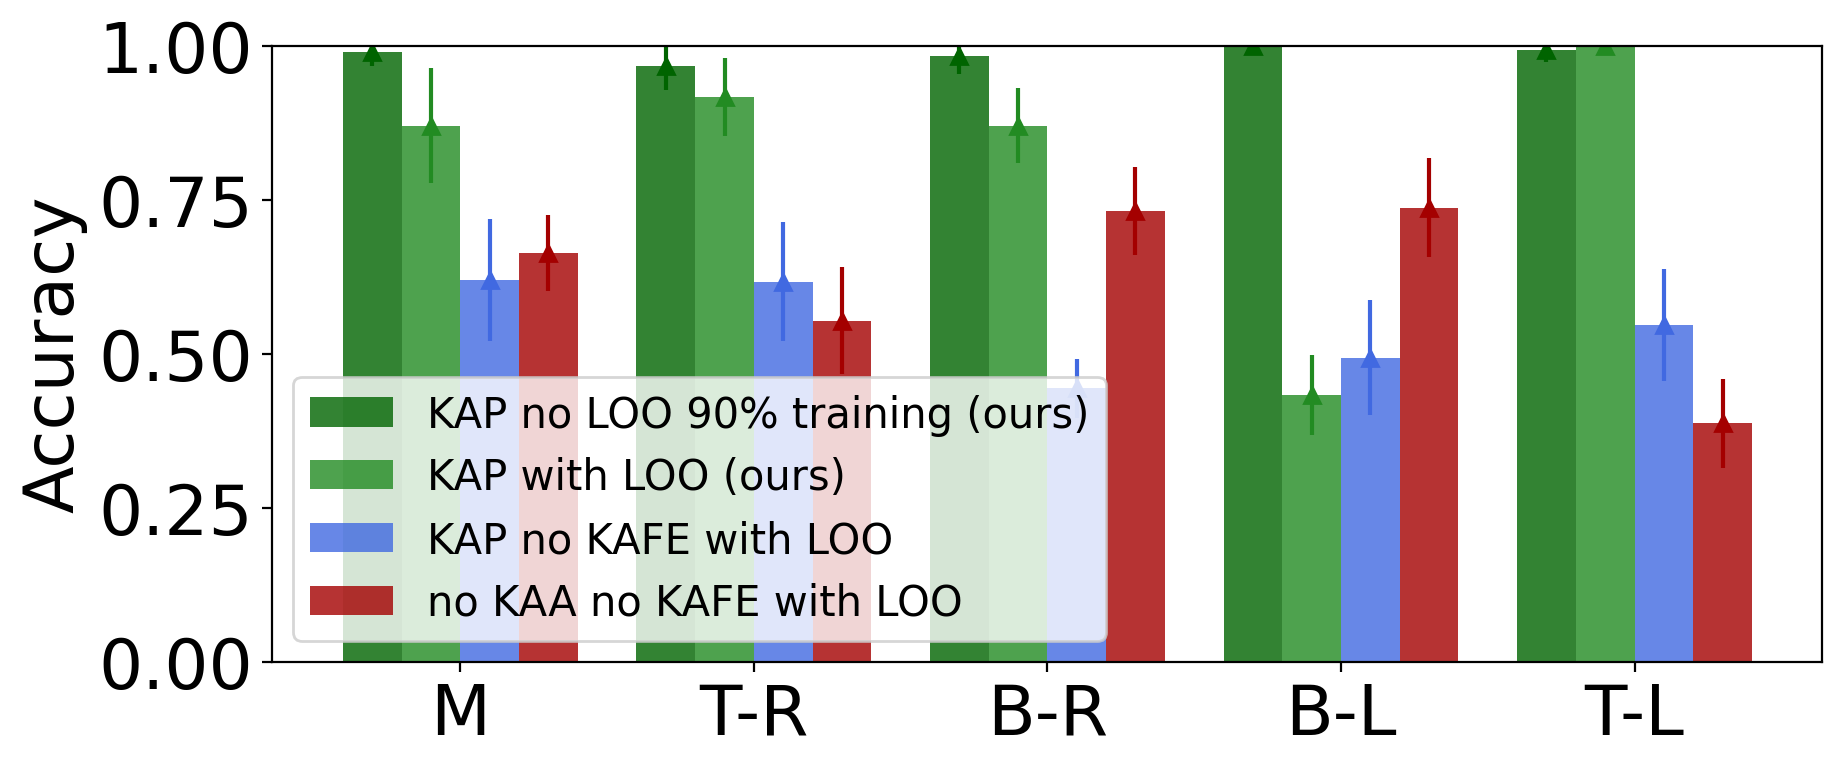

In [12]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
all_results = {
    "KAP no LOO 90% training (ours)": (kap_no_loo, "darkgreen"),
    "KAP with LOO (ours)": (kap_loo, "forestgreen"),
    "KAP no KAFE with LOO": (kap_fft, "royalblue"),
    "no KAA no KAFE with LOO": (no_kaa_fft, "#a40000")
}
mmap = {
    "middle": "M",
    "topright": "T-R",
    "topleft": "T-L",
    "bottomright": "B-R",
    "bottomleft": "B-L"
}
width = 0.20  # the width of the bars
plt.rcParams.update({'font.size': 15})
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 
plt.figure(figsize=(10,4), dpi=200)
for i,results in enumerate(all_results.keys()):
    color = all_results[results][1]
    locs = [all_results[results][0][multi][0] for multi in range(5)]
    locs = [mmap[x] for x in locs]
    avg = [all_results[results][0][multi][1]for multi in range(5)]
    std = [all_results[results][0][multi][2]for multi in range(5)]
    offset = width * i
    rects = plt.bar(np.arange(5) + offset, avg, width, label=results, alpha= 0.8, color=color)
    plt.errorbar(np.arange(5) + offset, avg, std, linestyle='None', marker='^', c=color)
    plt.xticks(np.arange(5) + (width * 1.5), locs)
plt.legend(loc='lower left', ncols=1)
plt.ylim(0,1)
plt.ylabel("Accuracy",fontdict={"fontsize": 25})

plt.savefig("results3.pdf")
plt.show()
        

In [13]:
average = np.array(np.array(kap_loo)[:,1], dtype=float)
kap_loo_average = np.average(average)
average = np.array(np.array(kap_fft)[:,1], dtype=float)
kap_fft_average = np.average(average)
average = np.array(np.array(no_kaa_fft)[:,1], dtype=float)
no_kaa_fft_average = np.average(average)

print(f'KAP with LOO average is: {kap_loo_average}')
print(f'KAP with LOO average - No KAA No KAFE without LOO average is: {kap_loo_average - no_kaa_fft_average}')
print(f'KAP with LOO average - No KAFE without LOO average is: {kap_loo_average - kap_fft_average}')
print(f'KAP with LOO average std across all locations is: {np.average(np.array(np.array(kap_loo)[:,2], dtype=float))}')



KAP with LOO average is: 0.8180000000000002
KAP with LOO average - No KAA No KAFE without LOO average is: 0.2037500000000002
KAP with LOO average - No KAFE without LOO average is: 0.27400000000000024
KAP with LOO average std across all locations is: 0.056438370989641606
